In [3]:
%matplotlib inline
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import andrews_curves

import random
from matplotlib.pyplot import plot, imshow
from scipy import ndimage, signal

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Deconv2D
from keras.models import Model
from keras import regularizers
from keras import backend as K_backend
from keras import objectives
from keras.utils import np_utils

# Test models
from keras.datasets import mnist

# Need this because otherwise the progbar freezes my Jupyter
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

from crossfire import VariationalAutoencoder2D

Using TensorFlow backend.


In [4]:
def add_null_channel(tensor):
    if tensor.ndim == 4:
        return tensor # do nothin
    assert tensor.ndim == 3, 'only works on 3d tensor right now'
    n, x, y = tensor.shape
    return tensor.reshape((n,x,y,1))

def nshow(img):
    if img.ndim == 2:
        imshow(img)
    elif img.ndim == 3:
        imshow(img[:,:,0])
        
def beforeafter(im1, im2, width=8, height=8):
    plt.figure(figsize=(width, height))
    plt.figure()
    nshow(im1)
    plt.title('original')
    plt.show()
    nshow(im2)
    plt.title('transformed')
    plt.show()
    
def sidebyside(im1, im2, width=8, height=4):
    plt.subplot(121)
    nshow(im1)
    plt.title('original')
    plt.subplot(122)
    nshow(im2)
    plt.title('transformed')
    plt.show()


In [5]:
class Autorectifier_MNIST_0(VariationalAutoencoder2D):
    """ Covolutional VAE which rectifies changes in scaling and rotation """

    def __init__(self,
                 input_shape=(56, 56, 1),
                 latent_dim=2,  # Size of the encoded vector
                 n_classes=10,  # number of classes in dataset
                 batch_size=100,  # size of minibatch
                 n_stacks=3,  # Number of convolayers to stack, this boosts performance of the network dramatically
                 intermediate_dim=256,  # Size of the dense layer after convs
                 n_filters=64,  # Number of filters in the first layer
                 px_conv=3,  # Default convolution window size
                 dropout_p=0.1,  # Default dropout rate
                 epsilon_std=1.0,  # This is the stddev for our normal-dist sampling of the latent vector
                 ):

        # This is my original crossfire network, and it works. As such, it has apprentice marks all over
        # Reconstructing as-is before tinkering
        # Based heavily on https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py
        # and https://groups.google.com/forum/#!msg/keras-users/iBp3Ngxll3k/_GbY4nqNCQAJ

        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size, epsilon_std=epsilon_std)



        # theano vs tensorflow ordering of size parameters
        if K_backend.image_dim_ordering() == 'th':
            self.original_img_size = (self.img_chns, self.img_rows, self.img_cols)
        else:
            self.original_img_size = (self.img_rows, self.img_cols, self.img_chns)


        # experimental
        def_conv = {'border_mode': 'same', 'activation': 'relu'}

        # Convolutional frontend filters as per typical convonets
        x_in = Input(batch_shape=(batch_size,) + self.original_img_size, name='main_input')
        conv_1 = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu')(x_in)
        conv_2 = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu',
                        subsample=(2, 2))(conv_1)
        stack = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu',
                       subsample=(2, 2), name='stack_base')(conv_2)

        # I call this structure the "stack". By stacking convo layers w/ BN and dropout, the performance
        # of the network increases dramatically. For MNIST, I like n_stacks=3.
        # Presumably, the deepness allows for greater richness of filters to emerge
        for i in range(n_stacks):
            stack = BatchNormalization()(stack)
            stack = Dropout(dropout_p)(stack)
            stack = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu',
                           name='stack_{}'.format(i), subsample=(1, 1))(stack)

        stack = BatchNormalization()(stack)
        conv_4 = Conv2D(n_filters*2, px_conv, px_conv, border_mode='same', activation='relu')(stack)

        # Densely connected layer after the filters
        flat = Flatten()(conv_4)
        hidden_1 = Dense(intermediate_dim, activation='relu', name='intermezzo')(flat)

        # This is the Variational Autoencoder reparameterization trick
        z_mean = Dense(latent_dim)(hidden_1)
        z_log_var = Dense(latent_dim)(hidden_1)

        # Make these instance vars so X-Ent can use them. Probably a better way out there
        self.z_mean = z_mean
        self.z_log_var = z_log_var

        # Part 2 of the reparam trick is sample from the mean-vec and std-vec (log_var). To do this, we utilize a
        # custom layer via Lambda class to combine the mean and log_var outputs and a custom sampling function
        # 'z' is our latent vector
        z = Lambda(self.sampling, output_shape=(latent_dim,), name='latent_z')([z_mean, z_log_var])

        # This marks the end of the encoding portion of the VAE

        # The 'classer' is a subnet after the latent vector, which will drive the distribution in order to
        # (hopefully) provide better generalization in classification
        # Note: in the original Crossfile I attach this layer to z_mean, rather than z, for reasons I cannot recall
        # I suspect this is because for classification, we do not care about the variance, just the mean of the vec
        # In this setup, we go straight to one-hot
        # Original uses normal init. Could try glorot or he_normal
        # todo: test behavior of attachment point of the classer, different inits
        classer_base = Dense(n_classes, init='normal', activation='softmax', name='classer_output')(self.z_mean)
        #         classer_base = Dense(n_classes, init='normal', activation='softmax', name='classer_output')(z)

        batch_size_dec = batch_size

        # On to Decoder. we instantiate these layers separately so as to reuse them later
        # e.g. for feeding in latent-space vectors, or (presumably) inspecting output
        decoder_hidden = Dense(intermediate_dim, activation='relu')
        decoder_upsample = Dense(n_filters * 14 * 14, activation='relu')

        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size_dec, n_filters, 14, 14)
        else:
            output_shape = (batch_size_dec, 14, 14, n_filters)

        decoder_reshape = Reshape(output_shape[1:])  # FC's, I don't understand why this is here

        # FC uses Deconv, but another example uses UpSample layers. See Keras Api: Deconvolution2D
        decoder_deconv_1 = Deconv2D(n_filters, px_conv, px_conv, output_shape,
                                    border_mode='same', activation='relu')
        decoder_deconv_2 = Deconv2D(n_filters, px_conv, px_conv, output_shape,
                                    border_mode='same', activation='relu')

        # Some more reshaping, presumably I need to modify this in order to use different shapes
        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size_dec, n_filters, 29, 29)
        else:
            output_shape = (batch_size_dec, 29, 29, n_filters)

        # more FC voodoo
        decoder_deconv_3_upsamp = Deconv2D(n_filters, 2, 2, output_shape, border_mode='valid', subsample=(2, 2),
                                           activation='relu')
        decoder_mean_squash = Conv2D(self.img_chns, 2, 2, border_mode='valid', activation='sigmoid', name='main_output')

        # Now, piecemeal the encoder together. IDK why this is done this manner, and not functional like the
        # encoder half. presumably, this is so we can inspect the output at each point
        hid_decoded = decoder_hidden(z)
        up_decoded = decoder_upsample(hid_decoded)
        reshape_decoded = decoder_reshape(up_decoded)
        deconv_1_decoded = decoder_deconv_1(reshape_decoded)
        deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
        x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
        x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

        # FC: build a digit generator that can sample from the learned distribution
        # todo: (un)roll this
        decoder_input = Input(shape=(latent_dim,))
        _hid_decoded = decoder_hidden(decoder_input)
        _up_decoded = decoder_upsample(_hid_decoded)
        _reshape_decoded = decoder_reshape(_up_decoded)
        _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
        _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
        _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
        _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)

        # Now we create the actual models. We also compile them automatically, this could be isolated later
        # Primary model - VAE
        self.model = Model(x_in, x_decoded_mean_squash)
        self.model.compile(optimizer='rmsprop', loss=self.vae_loss)

        # Crossfire network
        self.classifier = Model(x_in, classer_base)
        self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Ok, now comes the tricky part. See these references:
        # https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
        # I believe the names have to match the layer names, but are otherwise arbitrary
        self.crossmodel = Model(input=x_in, output=[x_decoded_mean_squash, classer_base])
        self.crossmodel.compile(optimizer='rmsprop',
                                loss={'main_output': self.vae_loss, 'classer_output': 'categorical_crossentropy'},
                                loss_weights={'main_output': 1.0, 'classer_output': 5.0})

        # build a model to project inputs on the latent space
        self.encoder = Model(x_in, self.z_mean)
        # reconstruct the digit pictures from latent space
        self.generator = Model(decoder_input, _x_decoded_mean_squash)

In [6]:
latent_dim=24
input_shape=(28, 28, 1)
vae_base = Autorectifier_MNIST_0(input_shape, latent_dim=latent_dim)
vae = vae_base.model
encoder = vae_base.encoder
generator = vae_base.generator

In [7]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (100, 28, 28, 1)      0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (100, 28, 28, 64)     640         main_input[0][0]                 
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (100, 14, 14, 64)     36928       convolution2d_1[0][0]            
____________________________________________________________________________________________________
stack_base (Convolution2D)       (100, 7, 7, 64)       36928       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [8]:
# ==== dataset handling - train the VAE on MNIST digits ===
batch_size = 100
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

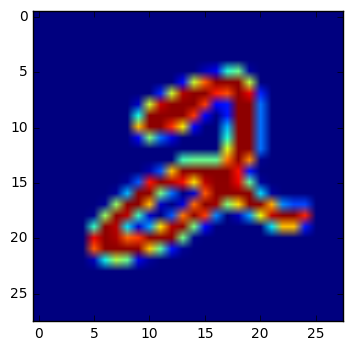

In [9]:
img = x_train[5]
imshow(img)

(28, 28)


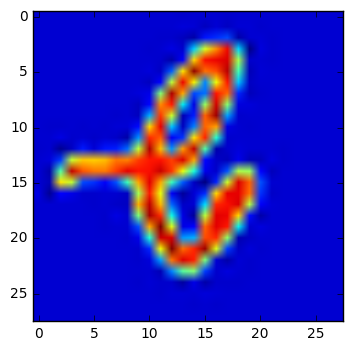

In [10]:

im2 = ndimage.rotate(img, random.randint(0,359), reshape=False)
print(im2.shape)
imshow(im2)

In [11]:
(random.randint(0, 100),) *2

(82, 82)

In [12]:
def rando_rotate(img):
    return ndimage.rotate(img, np.random.randint(0,359), reshape=False)

def rando_rotate_discrete(img, angle=30):
    positions = 360 // angle
    rot_ang = np.random.randint(0,positions) * angle
    return ndimage.rotate(img, rot_ang, reshape=False)

def rando_translate(img, max_shift_amt=14):
    rx, ry = random.randint(-max_shift_amt, max_shift_amt), random.randint(-max_shift_amt, max_shift_amt)
    im2 = np.roll(img, ry, axis=0)
    im2 = np.roll(im2, rx, axis=1)
    return im2

(56, 56, 29)


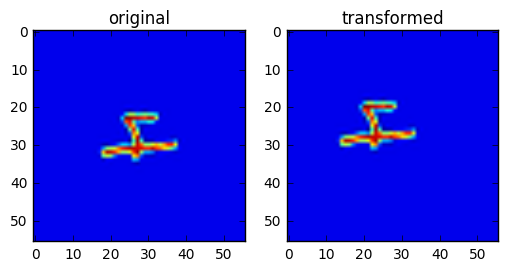

In [37]:
im2 = np.pad(img, 14, mode='edge')
# im2 = np.roll(im2, 14, axis=1)
print(im2.shape)
sidebyside(im2, rando_translate(im2))

In [15]:
x_train_r = [np.array([rando_rotate(im) for im in x_train]) for _ in range(5)]

In [16]:
x_test_r =  np.array([rando_rotate(im) for im in x_test])

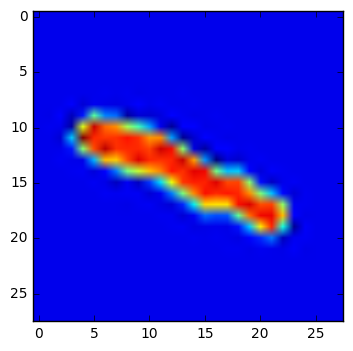

In [17]:
nshow(x_train_r[0][6])

In [20]:
x_train_r = [add_null_channel(x_train_r[i]) for i in range(5)]
x_train = add_null_channel(x_train)
x_test = add_null_channel(x_test)
x_test_r = add_null_channel(x_test_r)
x_train_r[0].shape

(60000, 28, 28, 1)

In [21]:
# assert 0, 'pause'
vae.fit(x_train_r[0], x_train,
        shuffle=True,
        nb_epoch=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=False, callbacks=[TQDMNotebookCallback()])

In [22]:
for i in range(5):
    vae.fit(x_train_r[i], x_train,
            shuffle=True,
            nb_epoch=1,
            batch_size=batch_size,
            validation_data=(x_test, x_test),
            verbose=False, callbacks=[TQDMNotebookCallback()])

In [23]:
prs = vae.predict(x_test_r[:100], batch_size=100)

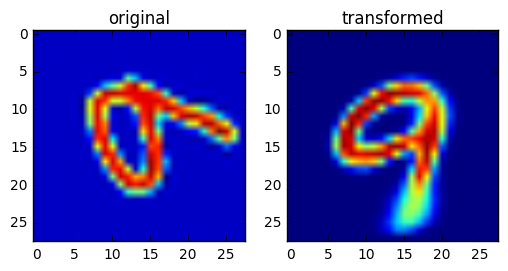

In [60]:
idx = 58
img = x_test_r[idx]
sidebyside(img, prs[idx])

# HELLS YES!!!

In [47]:
padding = ((0,0), (14, 14), (14, 14), (0, 0))
x_test_p = np.pad(x_test, padding, mode='edge')
x_train_p = np.pad(x_train, padding, mode='edge')

print(x_test_p.shape)

(10000, 56, 56, 1)


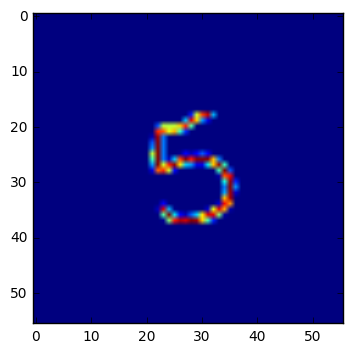

In [48]:
nshow(x_test_p[idx])

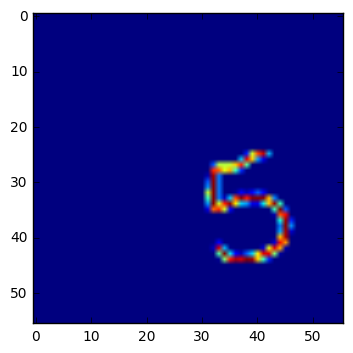

In [49]:
x_test_s = np.array([rando_translate(im) for im in x_test_p])
x_train_s = np.array([rando_translate(im) for im in x_train_p])

nshow(x_test_s[idx])

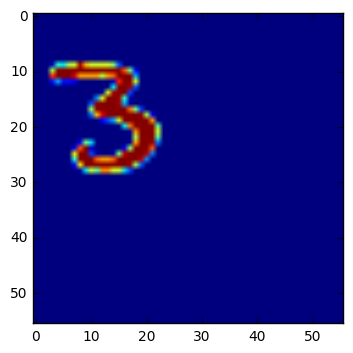

In [50]:
nshow(x_train_s[12])

In [51]:
latent_dim=24
input_shape=(56, 56, 1)
vae_base = Autorectifier_MNIST_0(input_shape, latent_dim=latent_dim)
vae = vae_base.model
encoder = vae_base.encoder
generator = vae_base.generator

In [52]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (100, 56, 56, 1)      0                                            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (100, 56, 56, 64)     640         main_input[0][0]                 
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (100, 28, 28, 64)     36928       convolution2d_4[0][0]            
____________________________________________________________________________________________________
stack_base (Convolution2D)       (100, 14, 14, 64)     36928       convolution2d_5[0][0]            
___________________________________________________________________________________________

In [53]:
print(x_train_s.shape, x_train_p.shape, x_test_s.shape, x_test_p.shape)

(60000, 56, 56, 1) (60000, 56, 56, 1) (10000, 56, 56, 1) (10000, 56, 56, 1)


In [54]:
vae.fit(x_train_s, x_train,
        shuffle=True,
        nb_epoch=5,
        batch_size=batch_size,
        validation_data=(x_test_s, x_test),
        verbose=False, callbacks=[TQDMNotebookCallback()])

### ok there is something screwy in the VAE where the output dimension is locked to 28x28. Need to fully parameterize that. 

In [61]:
prs = vae.predict(x_test_s[:100], batch_size=100)

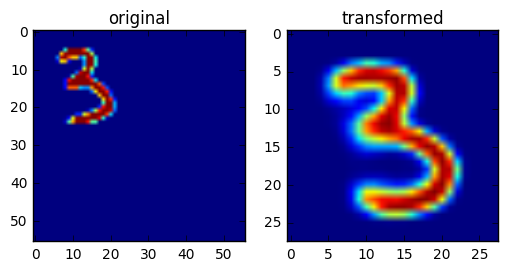

In [76]:
idx = 32
img = x_test_s[idx]
sidebyside(img, prs[idx])

In [ ]:
nshow(prs[idx])

# YES!! All together now!!

In [ ]:
x_train_r = []
x_test_r =  []
for i in range(4):
    x_train_r +=([rando_rotate_discrete(im) for im in x_train])
    print(i+1)
    
x_test_r = [rando_rotate(im) for im in x_test]
    
x_train_r = np.array(x_train_r)
x_test_r = np.array(x_test_r)

In [ ]:
x_train2 = np.concatenate([x_train,]*4, axis=0)
x_train2.shape

In [ ]:
print(x_train_r.shape, x_test_r.shape)

x_train_r = add_null_channel(x_train_r)
x_test_r = add_null_channel(x_test_r)

In [ ]:
x_test_pr = np.pad(x_test_r, padding, mode='edge')
x_train_pr = np.pad(x_train_r, padding, mode='edge')
x_test_sr = np.array([rando_translate(im) for im in x_test_pr])
x_train_sr = np.array([rando_translate(im) for im in x_train_pr])
print(x_test_sr.shape, x_train_sr.shape)

In [ ]:
nshow(x_test_sr[18])

In [ ]:
latent_dim=64
input_shape=(56, 56, 1)
vae_base = Autorectifier_MNIST_0(input_shape, latent_dim=latent_dim)
vae = vae_base.model
encoder = vae_base.encoder
generator = vae_base.generator

In [ ]:
vae.fit(x_train_sr, x_train2,
        shuffle=True,
        nb_epoch=5,
        batch_size=batch_size,
        validation_data=(x_test_sr, x_test),
        verbose=False, callbacks=[TQDMNotebookCallback()])

In [ ]:
prs = vae.predict(x_test_sr[:100], batch_size=100)

In [ ]:
idx = 32
nshow(x_test_sr[idx])

In [ ]:
nshow(prs[idx])

2